# **Conv1D-time series audio data**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/data_path.csv")

In [4]:
#Data Augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [5]:
def remove_silent(data):
    data=librosa.effects.trim(data, top_db = 30)[0]
    return data

In [6]:
def extract_features(data):
    data=data[:44100]
    zero_padding=tf.zeros([44100] - tf.shape(data), dtype=tf.float32)
    data=tf.concat([zero_padding, data], 0)
    data=np.array(data)
    return data


In [7]:
def get_features(path,i):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, sr=22050)
    data=remove_silent(data)
    
    # without augmentation
    if i==0:
      res1 = extract_features(data)
      result = np.array(res1)
      
    # data with noise
    if i==1:
      noise_data = noise(data)
      result = extract_features(noise_data)
      # result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    if i==2:
      new_data = stretch(data)
      data_stretch_pitch = pitch(new_data, sample_rate)
      result = extract_features(data_stretch_pitch)
      # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    for i in range(3):
        feature = get_features(path,i)
        X.append(feature)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [9]:
len(X),len(Y)

(4320, 4320)

In [10]:
# data = pd.DataFrame(X)
# data['labels'] = Y
# data.to_csv('audio_raw_data.csv', index=False)
# data.head()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

In [12]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [13]:
X2=np.expand_dims(X,axis=2)

In [14]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X2, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 44100, 1), (3240, 8), (1080, 44100, 1), (1080, 8))

In [15]:
#------------------------------------Conv1d---------------------------------------------------------------------#
model=Sequential()
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='tanh'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44100, 128)        768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22050, 128)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22050, 64)         41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11025, 64)        0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11025, 64)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 11025, 32)         1

In [16]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
n_epochs=50
history=model.fit(x_train, y_train, batch_size=64, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 38s 545ms/step - loss: 1.9132 - accuracy: 0.2815 - val_loss: 1.8544 - val_accuracy: 0.3093 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 25s 500ms/step - loss: 1.4379 - accuracy: 0.4929 - val_loss: 1.5596 - val_accuracy: 0.4556 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 25s 498ms/step - loss: 0.9239 - accuracy: 0.7071 - val_loss: 1.4665 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 25s 500ms/step - loss: 0.5982 - accuracy: 0.8182 - val_loss: 1.4373 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 25s 500ms/step - loss: 0.4139 - accuracy: 0.8818 - val_loss: 1.4150 - val_accuracy: 0.6009 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 25s 500ms/step - loss: 0.3053 - accuracy: 0.9275 - val_loss: 1.4489 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 25s 500ms/st

34/34 [==============================] - 4s 92ms/step - loss: 1.7647 - accuracy: 0.6185
Accuracy of our model on test data :  61.851853132247925 %


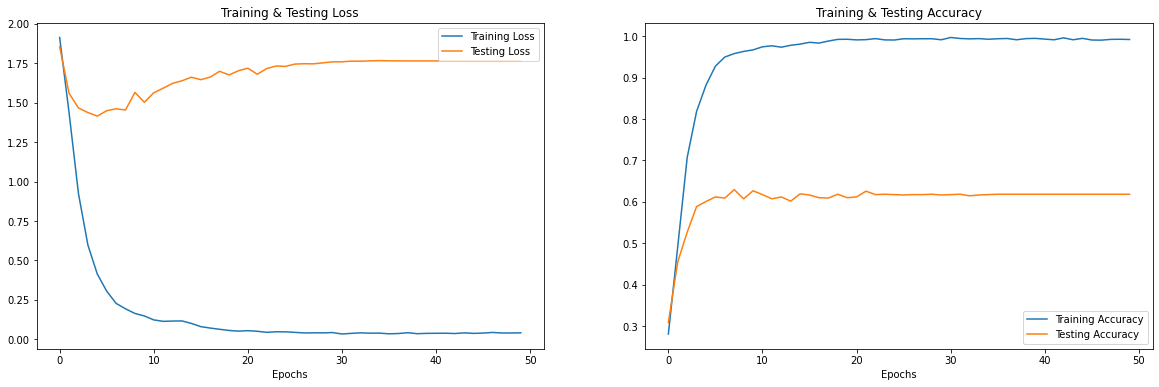

In [17]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(n_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [18]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 3s 79ms/step


In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df

,Predicted Labels,Actual Labels
0,calm,calm
1,angry,disgust
2,surprise,surprise
3,calm,calm
4,disgust,disgust
...,...,...
1075,surprise,surprise
1076,calm,calm
1077,disgust,disgust
1078,neutral,neutral


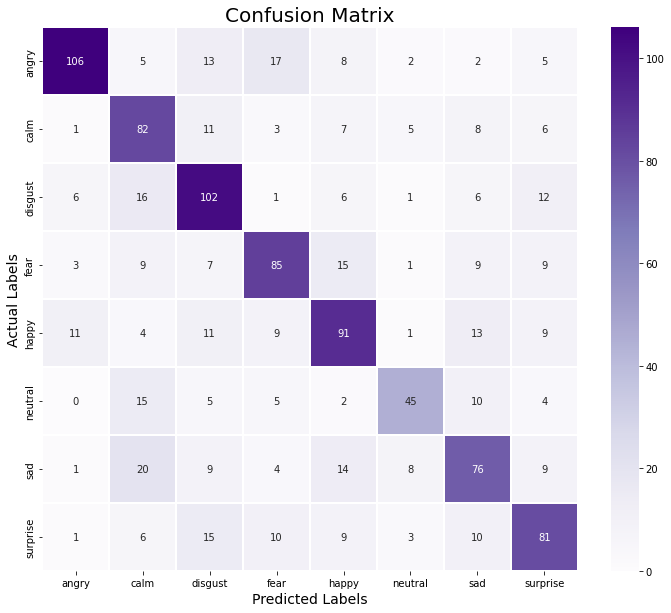

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.82      0.67      0.74       158
        calm       0.52      0.67      0.59       123
     disgust       0.59      0.68      0.63       150
        fear       0.63      0.62      0.62       138
       happy       0.60      0.61      0.60       149
     neutral       0.68      0.52      0.59        86
         sad       0.57      0.54      0.55       141
    surprise       0.60      0.60      0.60       135

    accuracy                           0.62      1080
   macro avg       0.63      0.61      0.62      1080
weighted avg       0.63      0.62      0.62      1080

